## YouTube Trending Project
* ### Machine Learning Models

### Table of Contents:
* 1.Exploratory Data Analysis
* 2.Data Cleaning
* 3.Modeling
    * 3.1 Predicting Likes
        * 3.1.1 Pre-processing Data
            * 3.1.1.1 Train-Test Split (80:20)
            * 3.1.1.2 Initializing Pre-processing Pipeline
        * 3.1.2 Hyperparameter Tuning (Gridsearch)
        * 3.1.3 Regressors
            * 3.1.3.1 Linear Regression
            * 3.1.3.2 Random Forest
            * 3.1.3.3 XGBoost
        * 3.1.4 Random Forest
            * 3.1.4.1 Feature Importance
        * 3.1.5 Likes Evaluation
    * 3.2 Predicting Views
        * 3.2.1 Pre-processing Data
            * 3.2.1.1 Train-Test Split (80:20)
            * 3.2.1.2 Initializing Pre-processing Pipeline
        * 3.2.2 Hyperparameter Tuning (Gridsearch)
        * 3.2.3 Regressors
            * 3.2.3.1 Linear Regression
            * 3.2.3.2 Random Forest
            * 3.2.3.3 XGBoost
        * 3.2.4 Random Forest
            * 3.2.4.1 Feature Importance
        * 3.2.5 Views Evaluation
    * 3.3 Predicting Comment Count
        * 3.3.1 Pre-processing Data
            * 3.3.1.1 Train-Test Split (80:20)
            * 3.3.1.2 Initializing Pre-processing Pipeline
        * 3.3.2 Hyperparameter Tuning (Gridsearch)
        * 3.3.3 Regressors
            * 3.3.3.1 Linear Regression
            * 3.3.3.2 Decision Trees
            * 3.3.3.3 Random Forest
        * 3.3.4 Random Forest
            * 3.1.4.1 Feature Importance

### 3. Machine Learning Models
##### Loading Data and Libraries

In [1]:
import helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Encoding and Data Split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Modeling
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Tuning
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Reading the stitched data
df = helpers.load_df("Data/Curated_US_Data.csv")

df.head()

,categoryId,likeRatio,likes_log,views_log,dislikes_log,comment_log,days_lapse,durationHr,durationMin,durationSec,titleLength,tagCount
0,25,0.876818,11.457423,15.708863,8.733755,10.990247,0.0,1,59,15,66,12
1,10,0.985548,14.211013,15.832615,9.288227,11.853311,0.0,0,2,58,42,22
2,10,0.974122,11.938376,14.220534,7.603898,9.306832,1.0,0,3,0,42,26
3,22,0.976673,13.299495,15.487011,8.859931,10.423709,2.0,0,5,55,35,0
4,10,0.984114,11.315194,13.667111,6.487684,8.402680,1.0,0,2,59,47,22


### 3.1 Predicting Likes
#### 3.1.1 Preprocessing Data
##### 3.1.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [2]:
X = df.drop(columns=['likes_log'])
y = df['likes_log']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.1.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [4]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       11.457423
1       14.211013
2       11.938376
3       13.299495
4       11.315194
          ...    
2731    12.388952
2732    10.343966
2733    13.291704
2734    10.807706
2735     8.847791
Name: likes_log, Length: 2736, dtype: float64

In [5]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'views_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.1.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [6]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-28 00:10:10,125] A new study created in memory with name: no-name-1ce9cc29-1cdd-4582-ada6-93771b0f507b
[I 2021-01-28 00:10:20,132] Trial 0 finished with value: 0.9817565514734218 and parameters: {'n_estimators': 389, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 11}. Best is trial 0 with value: 0.9817565514734218.
[I 2021-01-28 00:10:23,457] Trial 1 finished with value: 0.9606384913365961 and parameters: {'n_estimators': 220, 'max_depth': 39, 'min_samples_leaf': 14, 'min_samples_split': 10}. Best is trial 0 with value: 0.9817565514734218.
[I 2021-01-28 00:10:36,279] Trial 2 finished with value: 0.983592710244658 and parameters: {'n_estimators': 466, 'max_depth': 45, 'min_samples_leaf': 4, 'min_samples_split': 9}. Best is trial 2 with value: 0.983592710244658.
[I 2021-01-28 00:10:38,915] Trial 3 finished with value: 0.9712908834962678 and parameters: {'n_estimators': 160, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 5}. Best is trial 2 with value

In [7]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-28 00:22:16,683] A new study created in memory with name: no-name-267d0109-2a1e-4755-9ca8-8a07a388fa98
[I 2021-01-28 00:25:38,981] Trial 0 finished with value: 0.9164041540437946 and parameters: {'n_estimators': 147, 'max_depth': 12, 'eta': 0.706344352368108, 'subsample': 0.31112951631787433, 'colsample_bytree': 0.48989976811384806, 'gamma': 6, 'min_child_weight': 0.38643103574492044}. Best is trial 0 with value: 0.9164041540437946.
[I 2021-01-28 00:31:38,151] Trial 1 finished with value: 0.8584444646056708 and parameters: {'n_estimators': 459, 'max_depth': 14, 'eta': 0.8164563037527227, 'subsample': 0.4351773418927237, 'colsample_bytree': 0.39724053886540733, 'gamma': 0, 'min_child_weight': 0.9342654370093866}. Best is trial 0 with value: 0.9164041540437946.
[I 2021-01-28 00:48:07,686] Trial 2 finished with value: 0.9532754889666187 and parameters: {'n_estimators': 454, 'max_depth': 14, 'eta': 0.525931319454509, 'subsample': 0.45044786631322364, 'colsample_bytree': 0.924675

#### 3.1.3 Regressors
* ##### 3.1.3.1 Linear Regression
* ##### 3.1.3.2 Random Forest
* ##### 3.1.3.3 XGBoost


LinearRegression()
Model Score: 0.930
mae:  0.30764861304915814
mse:  0.1617673139041401
rmse:  0.40220307545335865 

RandomForestRegressor(max_depth=44, n_estimators=203)
Model Score: 0.989
mae:  0.09383526498042409
mse:  0.025246153070981044
rmse:  0.1588903806747943 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9010090416174096,
             eta=0.9197083497479718, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.919708371,
             max_delta_step=0, max_depth=1, min_child_weight=0.5147181954357406,
             missing=nan, monotone_constraints='()', n_estimators=499, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8038635404777886,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.997
mae:  0.05738981564220605
mse:  0.0059333419493

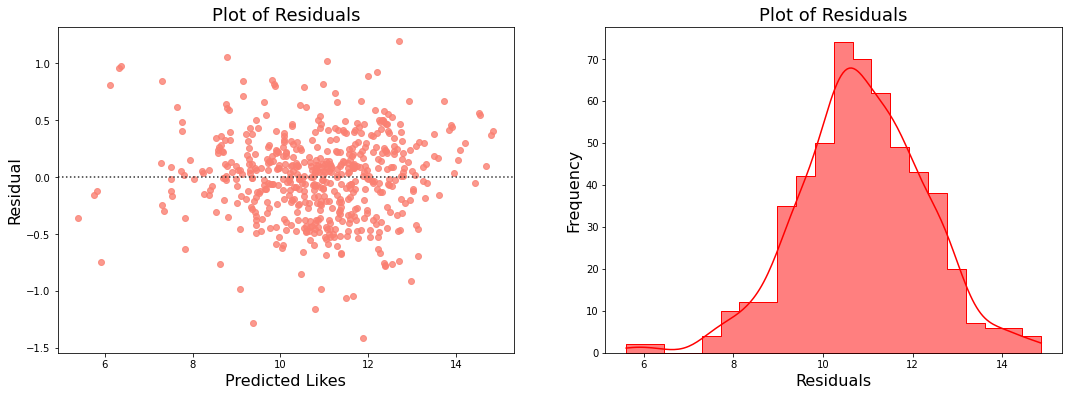

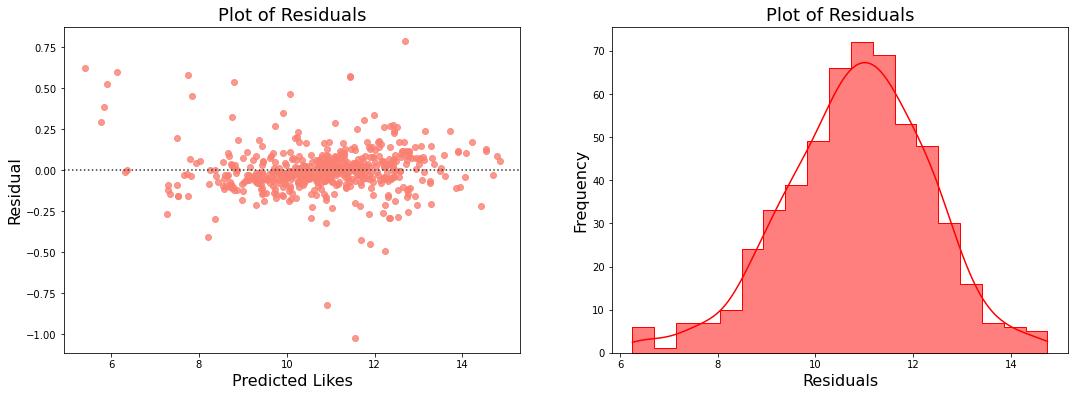

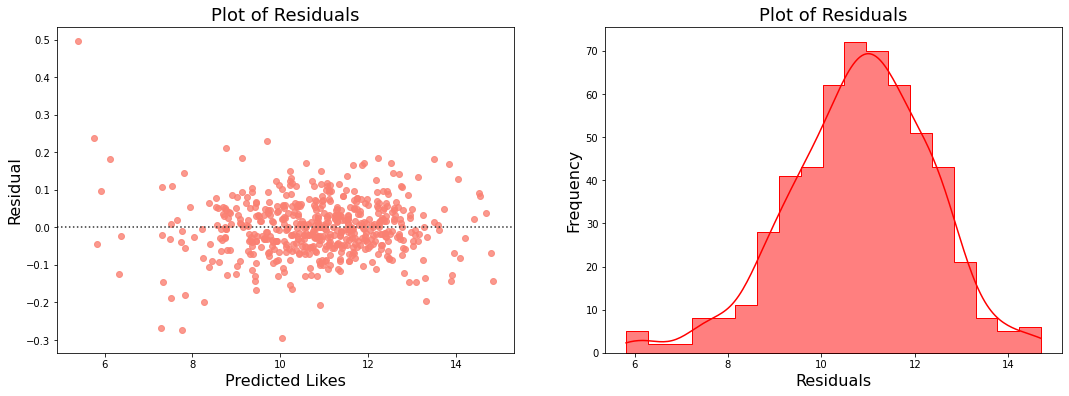

In [8]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    
    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    data = pd.DataFrame(data = d1)
    # Residual Plot 1
    fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
    g1 = sns.residplot(x= y_test, y= y_pred, ax=ax1[0], data = data, color="salmon")
    g1.set_xlabel('Predicted Likes', fontsize=16)
    g1.set_ylabel('Residual', fontsize=16)
    g1.set_title("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    g2 = sns.histplot(x=y_pred, ax=ax1[1], data = data, element="step", color="red", kde=True)
    g2.set_xlabel('Residuals', fontsize=16)
    g2.set_ylabel('Frequency', fontsize=16)
    g2.set_title("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = data, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)


#### 3.1.4 Random Forest Regressor

In [9]:
reg = RandomForestRegressor(**{'n_estimators': 456, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 3}, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=16, min_samples_split=3, n_estimators=456,
                      oob_score=True)
Model Train Score: 0.998
Model OOB Score: 0.986
Model Test Score: 0.989


##### 3.1.4.1 Feature Importance

In [10]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
3,dislikes_log,0.589859
1,likeRatio,0.155545
0,categoryId,0.138797
2,views_log,0.092022
5,days_lapse,0.003611
6,durationHr,0.002259
4,comment_log,0.001095
8,durationSec,0.000365
7,durationMin,0.000361
9,titleLength,0.000005


#### 3.1.5 Likes Evaluation

In [11]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.0935712407662948
mse:  0.024606980835381438
rmse:  0.15686612392540794
r2:  0.9893882585149705


In [12]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,16246.0,1.925249e+04
1,477871.0,4.153243e+05
2,162807.0,1.770244e+05
3,1267051.0,1.074903e+06
4,199667.0,2.454238e+05
...,...,...
543,20055.0,2.860665e+04
544,51067.0,6.179067e+04
545,6624.0,6.372225e+03
546,23598.0,2.420900e+04


### 3.2 Predicting Views
#### 3.2.1 Preprocessing Data
##### 3.2.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [13]:
df = helpers.load_df("Data/Curated_US_Data.csv")

X = df.drop(columns=['views_log'])
y = df['views_log']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.2.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       15.708863
1       15.832615
2       14.220534
3       15.487011
4       13.667111
          ...    
2731    14.933087
2732    12.728645
2733    16.079583
2734    13.822260
2735    12.871561
Name: views_log, Length: 2736, dtype: float64

In [16]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'likes_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.2.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [17]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-28 03:19:26,304] A new study created in memory with name: no-name-3f4cf3af-1266-47e1-8f3b-402e21e1d580
[I 2021-01-28 03:19:32,564] Trial 0 finished with value: 0.8747928781219061 and parameters: {'n_estimators': 437, 'max_depth': 14, 'min_samples_leaf': 15, 'min_samples_split': 10}. Best is trial 0 with value: 0.8747928781219061.
[I 2021-01-28 03:19:41,660] Trial 1 finished with value: 0.9120689657745159 and parameters: {'n_estimators': 318, 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5}. Best is trial 1 with value: 0.9120689657745159.
[I 2021-01-28 03:19:47,610] Trial 2 finished with value: 0.8808219832146764 and parameters: {'n_estimators': 360, 'max_depth': 35, 'min_samples_leaf': 12, 'min_samples_split': 10}. Best is trial 1 with value: 0.9120689657745159.
[I 2021-01-28 03:19:49,429] Trial 3 finished with value: 0.863192492652956 and parameters: {'n_estimators': 222, 'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 2}. Best is trial 1 with va

In [18]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-28 03:34:40,949] A new study created in memory with name: no-name-153cf981-cd22-4bfc-ab01-168bc6e79dc6
[I 2021-01-28 03:34:41,398] Trial 0 finished with value: 0.8774583121622719 and parameters: {'n_estimators': 121, 'max_depth': 6, 'eta': 0.8978642583625456, 'subsample': 0.9065177615492911, 'colsample_bytree': 0.41358201576630604, 'gamma': 0, 'min_child_weight': 0.4879446473022957}. Best is trial 0 with value: 0.8774583121622719.
[I 2021-01-28 03:34:42,729] Trial 1 finished with value: 0.7831285695507213 and parameters: {'n_estimators': 325, 'max_depth': 12, 'eta': 0.9038071998282186, 'subsample': 0.31346561163286973, 'colsample_bytree': 0.209566045928622, 'gamma': 8, 'min_child_weight': 0.1187267707357502}. Best is trial 0 with value: 0.8774583121622719.
[I 2021-01-28 03:34:44,707] Trial 2 finished with value: 0.9109375167910787 and parameters: {'n_estimators': 423, 'max_depth': 13, 'eta': 0.06747842207969691, 'subsample': 0.6864457583080957, 'colsample_bytree': 0.14148736

#### 3.2.3 Regressors
* ##### 3.2.3.1 Linear Regression
* ##### 3.2.3.2 Random Forest
* ##### 3.2.3.3 XGBoost


LinearRegression()
Model Score: 0.879
mae:  0.2944756775768164
mse:  0.15599691668124369
rmse:  0.3949644498954858 

RandomForestRegressor(max_depth=47, n_estimators=439)
Model Score: 0.932
mae:  0.20387433470784627
mse:  0.08794405397097775
rmse:  0.2965536274790409 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5633257990855877,
             eta=0.0701150226012951, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0701150224,
             max_delta_step=0, max_depth=13, min_child_weight=0.867540875995138,
             missing=nan, monotone_constraints='()', n_estimators=224, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8957747223078069,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.949
mae:  0.1633702848893916
mse:  0.065698807201910

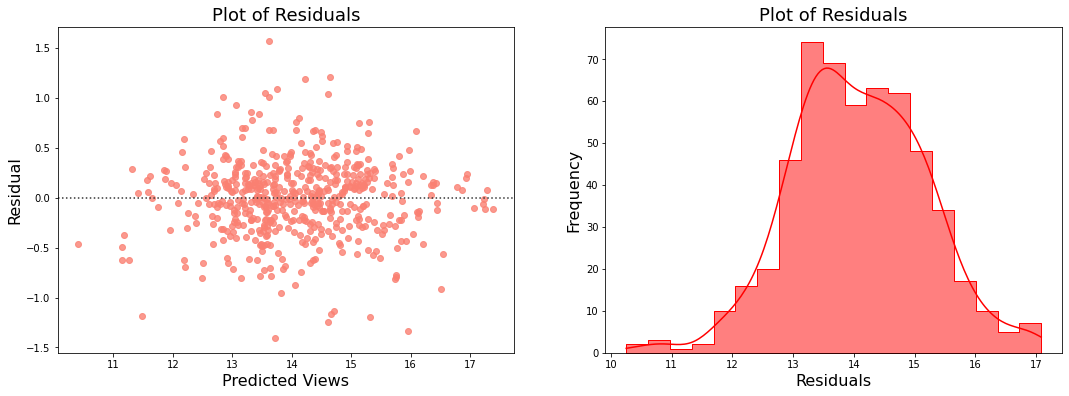

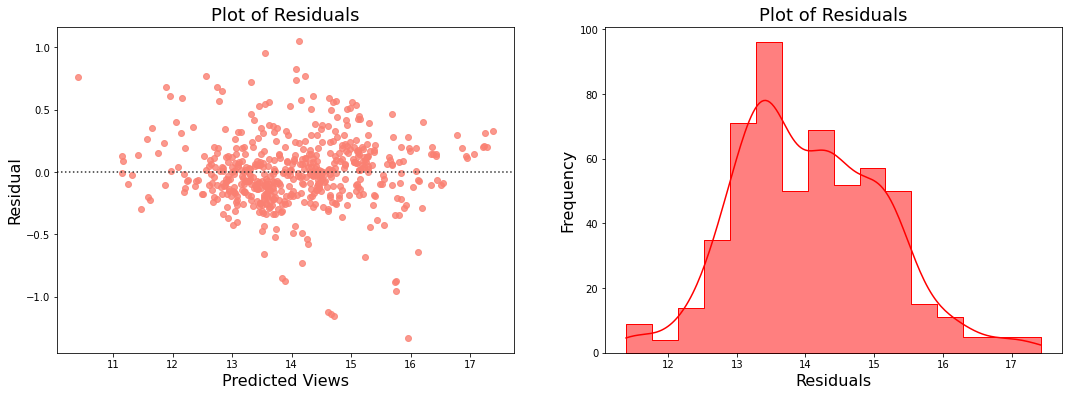

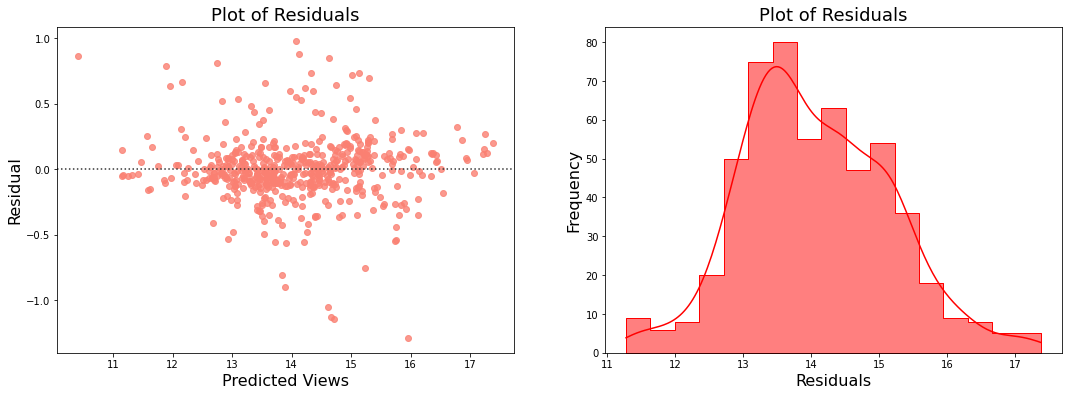

In [19]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)

    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    data = pd.DataFrame(data = d1)
    # Residual Plot 1
    fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
    g1 = sns.residplot(x= y_test, y= y_pred, ax=ax1[0], data = data, color="salmon")
    g1.set_xlabel('Predicted Views', fontsize=16)
    g1.set_ylabel('Residual', fontsize=16)
    g1.set_title("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    g2 = sns.histplot(x=y_pred, ax=ax1[1], data = data, element="step", color="red", kde=True)
    g2.set_xlabel('Residuals', fontsize=16)
    g2.set_ylabel('Frequency', fontsize=16)
    g2.set_title("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = data, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)

#### 3.2.4 Random Forest Regressor

In [20]:
reg = RandomForestRegressor(**rfTrial.params, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=47, n_estimators=439, oob_score=True)
Model Train Score: 0.990
Model OOB Score: 0.923
Model Test Score: 0.933


##### 3.2.4.1 Feature Importance

In [21]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
2,likes_log,0.669134
1,likeRatio,0.192339
3,dislikes_log,0.016932
5,days_lapse,0.015566
0,categoryId,0.014809
6,durationHr,0.013658
4,comment_log,0.010422
9,titleLength,0.000383
7,durationMin,0.000346
8,durationSec,0.000154


#### 3.2.5 Views Evaluation

In [22]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.20338239639770467
mse:  0.08662888084135646
rmse:  0.2943278458477153
r2:  0.9328647917073768


In [23]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,1138317.0,1.541053e+06
1,6466733.0,6.197046e+06
2,3670365.0,3.895563e+06
3,10925330.0,1.358157e+07
4,10835047.0,6.962573e+06
...,...,...
543,2366855.0,2.220697e+06
544,1020321.0,7.554866e+05
545,902733.0,5.712560e+05
546,696658.0,5.342526e+05
